In [1]:
%matplotlib inline
import re
import getpass
import gmaps
import requests
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
from urllib.parse import urljoin
from IPython.display import clear_output, display
from parse import parse
import yaml
import time
import os
import sys
import pandas as pd
import xarray as xr
from shapely.wkb import loads
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.point import Point
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt

#adding prognos tools
sys.path.insert(0, "/home/jose-luis/Envs/niva_prognos/PROGNOS/")
from prognos_tools.encrypt import decryptString
from prognos_tools.Basin import Basin


gmapsToken=b'gAAAAABctxJp5wE73qK6U5VieCi0WXNnNex4KxLZHutsESa8fW9v43lLa1Ag0qsxKFjXXo9MBAdvUpqJPW-QmCE0gH_Opf9g4xAG1VaI2WarO_xDZg44VLMCHkd_6O8ofgp8u4VuFBMr'
key = getpass.getpass('Password: ')
apiKey = decryptString(gmapsToken,key)
gmaps.configure(api_key=apiKey)
del key,apiKey

#Creating folder to store temporary files and downloaded data
saveFolder = './DownloadedData/'

args = [saveFolder,]
!!rm -rf {args[0]} && mkdir -p {args[0]}

Password: ········


[]

# Getting list of openDAP links with high-resolution (1km2) temperature and precipitation data

In [2]:
getList = False

baseURL = 'http://thredds.met.no/thredds/catalog/ngcd/version_19.03/catalog.html'
# varsToGet = ['TX','TN','TG','RR']
varsToGet = ['TG','RR']
model = 'type1'
listFolder = os.path.abspath('./' + model + 'Lists') #Folder where list of links will be saved

args=[]
if getList:
    args = [listFolder,]
!! {args[0]} && mkdir -p {args[0]}

only_a_tags = SoupStrainer("a", href=True)

def getSoup(url,re_str):
    request=requests.get(url)
    soup=BeautifulSoup(request.content,'lxml',parse_only=only_a_tags)
    link_soup=soup.find_all('a',text=re.compile(re_str))
    links=[]
    for i in link_soup:
        links.append(urljoin(url,i['href']))
    return links

def getFileList(var):
    allLinks=[]
    for var_link in getSoup(baseURL,var):
        for model_link in getSoup(var_link,model):
            for year_link in getSoup(model_link,'^[0-9]{4}/$'):
                print('Processing {}'.format(year_link))
                for month_link in getSoup(year_link,'^[0-9]{2}/$'):
                    for day_link in getSoup(month_link,'\\.nc$'):
                        for opendap_link in getSoup(day_link,'^/thredds/dodsC/'):
                            allLinks.append(re.sub(r'\.html$', '', opendap_link))
    return allLinks
    
# display(listFolder)
if getList:
    links = []
    for i in varsToGet:
        #Getting all links for variable
        links.append(getFileList(i))
        #Saving paths to file
        with open(os.path.join(listFolder , i + '_' + model + '.txt'), 'w') as f:
            for item in links[-1]:
                f.write("%s\n" % item)

In [3]:
display(listFolder)
if getList:
    args = [listFolder,]
!! rm -rf {args[0]} && mkdir -p {args[0]}

'/home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/delineateBasin/type1Lists'

[]

## Querying extent of the basin
### Creating a VM with the geodatabase on it

In [4]:
machineInfo={}
#Vm characteristics
machineInfo['instance'] = 'storelva-basin'
machineInfo['username'] = 'jose-luis'
machineInfo['image'] = 'geonorway'
machineInfo['imageProject'] = 'nivacatchment'
machineInfo['keyDir'] = '/home/jose-luis/.ssh/threddsBasin'
machineInfo['diskSize'] = '200GB'
machineInfo['region'] = 'europe-west3-a'
machineInfo['machineType'] = 'n1-standard-4'
machineInfo['keyFile'] = F'{os.path.join(machineInfo["keyDir"],machineInfo["username"])}'
machineInfo['pubKeyFile'] = F'{machineInfo["keyFile"] + ".pub"}'

# #Folder to store results and intermediary scripts and basin info
# basinFolder = './basinResults/'

#Actually 
# basinGenerator = basin.Basin(instance,username,region,keyDir,machineType)
basinGenerator = Basin(machineInfo)
basinGenerator.instantiate(fabfile='/home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py')
print("The ip of the google cloud instance is {}".format(basinGenerator.ip))

#Testing connection to instance
basinGenerator.callPopen('gcloud compute ssh {username}@{instance} --zone {region}'.format(
**basinGenerator.machineInfo))

Creating instance storelva-basin...
NAME            ZONE            MACHINE_TYPE   PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
storelva-basin  europe-west3-a  n1-standard-4               10.156.0.10  35.198.118.133  RUNNING
Created [https://www.googleapis.com/compute/beta/projects/nivacatchment/zones/europe-west3-a/instances/storelva-basin].
 - Disk size: '200 GB' is larger than image size: '20 GB'. You might need to resize the root repartition manually if the operating system does not support automatic resizing. See https://cloud.google.com/compute/docs/disks/persistent-disks#repartitionrootpd for details.

(b"Generating public/private rsa key pair.\nYour identification has been saved in /home/jose-luis/.ssh/threddsBasin/jose-luis.\nYour public key has been saved in /home/jose-luis/.ssh/threddsBasin/jose-luis.pub.\nThe key fingerprint is:\nSHA256:cyRbcP9bMHkUAi7QNrU3CA9r0C5DlpHDhKclAdgNQYg jose-luis\nThe key's randomart image is:\n+---[RSA 2048]----+\n|. ===.==Booo.. .o|\n|Eo . +

### Getting basins extent

In [5]:
#Schema were processing will be done
schema = 'metno'

#Getting basin outlets from yaml file
stationsFile = 'storelva.yaml'
stations = yaml.safe_load(open(stationsFile))
display(stations)

#Actually processing the basin
geoResultsFolder='./geoResults'
basinGenerator.getBasinLayers(stationsFile,schema,saveFolder=geoResultsFolder)
    
# # Now we delete the basinGenerator vm
# basinGenerator.kill()

[{'station': {'buffer': 100000,
   'epsg': 4326,
   'station_id': 1,
   'longitude': 8.9795,
   'latitude': 58.6687,
   'station_name': 'Storelva'}}]

'Directory should be created'

Gonna create the getBasin.sh file
./geoResults/getBasin.sh
fab -f /home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py runScript:./geoResults/getBasin.sh,True
[35.198.118.133] Executing task 'runScript'
[35.198.118.133] Executing task 'setup'
[35.198.118.133] put: ./geoResults/getBasin.sh -> getBasin.sh
[35.198.118.133] run: chmod +x getBasin.sh
[35.198.118.133] run: ./getBasin.sh
[35.198.118.133] out: NOTICE:  table "stations" does not exist, skipping
[35.198.118.133] out:  initializestations 
[35.198.118.133] out: --------------------
[35.198.118.133] out:  
[35.198.118.133] out: (1 row)
[35.198.118.133] out: 
[35.198.118.133] out:  addstations 
[35.198.118.133] out: -------------
[35.198.118.133] out:  
[35.198.118.133] out: (1 row)
[35.198.118.133] out: 
[35.198.118.133] out: NOTICE:  schema "metno" does not exist, skipping
[35.198.118.133] out:  initializeresultsschema 
[35.198.118.133] out: -------------------------
[35.198.118.133] out:  
[35.198.118.133] out: (1 r

### Displaying basins

In [6]:
with open(os.path.join(geoResultsFolder,'gmaps.txt'), 'r') as f:
    lines = f.read().splitlines()
    
fig = gmaps.figure()
fig.add_layer(gmaps.geojson_layer(yaml.safe_load(lines[0])))

lines[2:] = [i.split(';') for i in lines[2:]]
outlets = [{"name": i[0], "area": i[3]} for i in lines[2:]]
locations = [(float(i[2]),float(i[1])) for i in lines[2:]]
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Area</dt><dd>{area} km<sup>2</sup></dd>
</dl>
"""                                                
outlet_info = [info_box_template.format(**outlet) for outlet in outlets]                                                 
marker_layer = gmaps.marker_layer(locations, info_box_content=outlet_info)
fig.add_layer(marker_layer)

fig

Figure(layout=FigureLayout(height='420px'))

# Getting data from metno thredds servers
## Creating a virtual machine with the fimex utility

In [7]:
machineInfo={}
#Vm characteristics
machineInfo['instance'] = 'fimexin'
machineInfo['username'] = 'jose-luis'
machineInfo['image'] = 'fimex'
machineInfo['imageProject'] = 'nivacatchment'
machineInfo['diskSize'] = '200GB'
machineInfo['keyDir'] = '/home/jose-luis/.ssh/fimex'
machineInfo['region'] = 'europe-north1-c'
machineInfo['machineType'] = 'n1-standard-32'
machineInfo['keyFile'] = F'{os.path.join(machineInfo["keyDir"],machineInfo["username"])}'
machineInfo['pubKeyFile'] = F'{machineInfo["keyFile"] + ".pub"}'

hasBeenDownloaded = True
if not hasBeenDownloaded:
    fimexGenerator = Basin(machineInfo)
    fimexGenerator.instantiate(fabfile='fabfile_fimex.py')
    print("The ip of the google cloud instance is {}".format(fimexGenerator.ip))

    #Need to wait until the instance is up and running. There must be a better way.
    time.sleep(10)

    #Testing connection to instance
    fimexGenerator.callPopen('gcloud compute ssh {username}@{instance} --zone {region}'.format(
                             **fimexGenerator.machineInfo))

## Creating cfg file for download

In [8]:
cfgTemplate='''[extract]
reduceToBoundingBox.south={south}
reduceToBoundingBox.north={north}
reduceToBoundingBox.west={west}
reduceToBoundingBox.east={east}
selectVariables={variable}
'''

## Getting all variables for all basins using fimex

In [9]:
#Getting all boundaries to download:
hasBeenDownloaded = True
if not hasBeenDownloaded:
    args=[]
    with open(os.path.join(geoResultsFolder,'box.txt'), 'r') as f:
        lines = f.read().splitlines()
    boxes = [parse('BOX({west} {south},{east} {north})',i.split(';')[1]) for i in lines]
    names =  [re.split(';|,|\s',i)[0] for i in lines]
    # import os
    for i in varsToGet:
        #Getting only dates from 2010 to 2016
    #     args = [os.path.join(listFolder, 
    #                          i + '_' + model
    #                         ), 
    #             "2000", "2018"
    #            ]
    #    !!cat {args[0]}.txt | grep -E `seq -s \| {args[1]} {args[2]}` > {args[0]}_mini.txt
    #     'head -n 40 {0}.txt > {0}_mini.txt'.format(i + '_' + model)
        currentDict = boxes[0].named
        currentDict['variable'] = i
        with open('box.cfg','w') as f:
            f.write(cfgTemplate.format(**currentDict))
        for j in names:
            fimexGenerator.getNcDataForBox(os.path.join(listFolder, i + '_' + model) + '.txt',
                                      'box.cfg',
                                      i + '_' + j + '.nc'
                                      )   

## Intersecting basin and nc file 

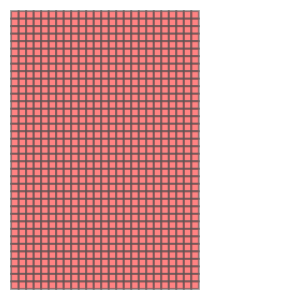

In [10]:
# Creating a grid from the nc file
temperatureFile = os.path.abspath('./TG_Storelva.nc')
nc_data = xr.open_dataset(temperatureFile)
temperature = nc_data.TG;
nc_shape = temperature.shape
X = nc_data.X.values
Y =nc_data.Y.values
nc_data.close()

cnt = 0
grid = list()
for i in X:
    for j in Y:
        left = i-500
        right = i+500
        bottom = j-500
        top = j+500
        p1 = Point(left,bottom)
        p2 = Point(left,top)
        p3 = Point(right,top)
        p4 = Point(right,bottom)
        pointList = [p1,p2,p3,p4,p1]
        poly = Polygon([[p.x,p.y] for p in pointList])
        poly.sid = cnt 
        grid.append(poly)
        cnt += 1
        
grid = MultiPolygon(grid)
display(grid)
        


In [11]:
# Uploading the grid to the geodatabase
scriptsFolder = os.path.abspath('./scripts')
basinGenerator.vmScript = '''#!/bin/bash

read -r -d '' sql<<-EOM
UPDATE metno.resultsshp SET basin = ST_MakeValid(basin); 
DROP TABLE IF EXISTS metno.dataBoundaries;
CREATE TABLE metno.dataBoundaries(sid SERIAL PRIMARY KEY, boundary geometry(MULTIPOLYGON, 3035) );
INSERT INTO metno.dataBoundaries(boundary) VALUES (ST_SetSRID('{hexStr}'::geometry,3035));
DROP INDEX IF EXISTS metno_data_boundary_gix;
CREATE INDEX metno_data_boundary_gix ON metno.dataBoundaries USING GIST(boundary);
DROP INDEX IF EXISTS metno_basins_gix:
CREATE INDEX metno_basins_gix ON metno.resultsShp USING GIST(basin);
EOM
echo $sql | psql -d geonorway
'''.format(hexStr=grid.wkb_hex)

basinGenerator.runScript(saveFolder=scriptsFolder,scriptName='uploadGrid.sh')


[35.198.118.133] out: DROP INDEX
[35.198.118.133] out: CREATE INDEX
[35.198.118.133] out: ERROR:  syntax error at or near ":"
[35.198.118.133] out: LINE 1: DROP INDEX IF EXISTS metno_basins_gix: CREATE INDEX metno_ba...
[35.198.118.133] out:                                              ^
[35.198.118.133] out: 


Done.
Disconnecting from 35.198.118.133... done.



In [12]:
# Intersecting grid with basin and getting area of the intersection
basinGenerator.vmScript = '''#!/bin/bash

read -r -d '' sql<<-EOM
DROP TABLE IF EXISTS test_dump;
CREATE TABLE test_dump AS
SELECT (ST_Dump(boundary)).path[1] as sid, (ST_Dump(boundary)).geom as geom
FROM metno.dataBoundaries;

CREATE INDEX dump_idx ON test_dump USING GIST(geom);

DROP TABLE IF EXISTS subdivided_geoms;
CREATE TABLE subdivided_geoms AS
SELECT ST_Subdivide(basin,32) AS geom
FROM metno.resultsShp
WHERE station_name ='Storelva';

CREATE INDEX subdivided_idx ON test_dump USING GIST(geom);

DROP TABLE IF EXISTS metno.areas;
CREATE TABLE metno.areas AS
WITH biglim AS (
    SELECT a.sid,ST_Area(ST_Intersection(b.geom, a.geom)) AS area FROM  test_dump AS a, subdivided_geoms AS b
    WHERE ST_Intersects(a.geom,b.geom)
) 
SELECT sid,SUM(area) as area FROM biglim
GROUP BY sid;
EOM
echo $sql | psql -d geonorway

echo "\COPY (SELECT * FROM metno.areas) TO '/home/jose-luis/areas.txt' DELIMITER ';';" | psql -d geonorway
'''.format(hexStr=grid.wkb_hex)

basinGenerator.runScript(saveFolder=scriptsFolder,scriptName='getIntersection.sh')

#Downloading the results
basinGenerator.callPopen('fab -f {} downloadFile:{},{}'.format(basinGenerator.fabfile,
                                                      'areas.txt',
                                                      os.path.join(geoResultsFolder,'areas.txt')
                                                     )
                        )


[35.198.118.133] out: CREATE INDEX
[35.198.118.133] out: NOTICE:  table "areas" does not exist, skipping
[35.198.118.133] out: DROP TABLE
[35.198.118.133] out: SELECT 479
[35.198.118.133] out: COPY 479
[35.198.118.133] out: 


Done.
Disconnecting from 35.198.118.133... done.

[35.198.118.133] Executing task 'downloadFile'
[35.198.118.133] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/delineateBasin/geoResults/areas.txt <- /home/jose-luis/areas.txt

Done.
Disconnecting from 35.198.118.133... done.


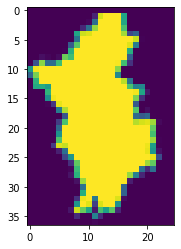

In [13]:
#Getting weight array from area file
weights = pd.read_csv( os.path.join(geoResultsFolder,'areas.txt'),delimiter=';', header=None, names=['idx','area'])

idx = weights.idx.values
weight = weights.area.values

#Getting the in a 2d array
weightArray = np.zeros((nc_shape[1:]))
arrayIdx = np.unravel_index(idx,nc_shape[2:0:-1])
for i,j,k in zip(arrayIdx[1],arrayIdx[0],weight):
    weightArray[i][j] = k;

plt.imshow(weightArray)

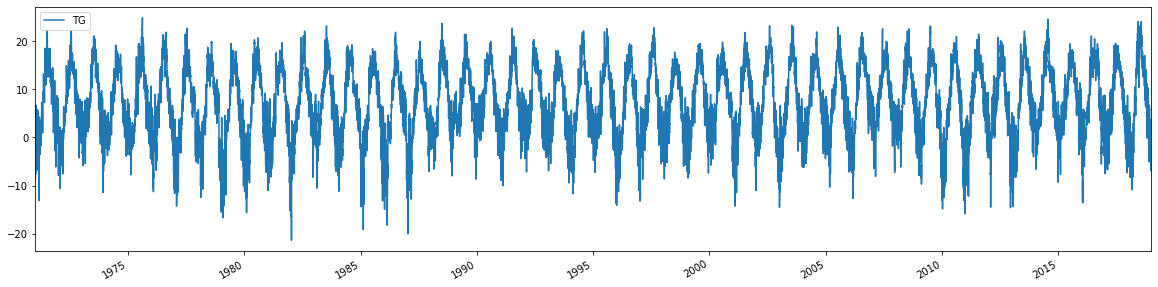

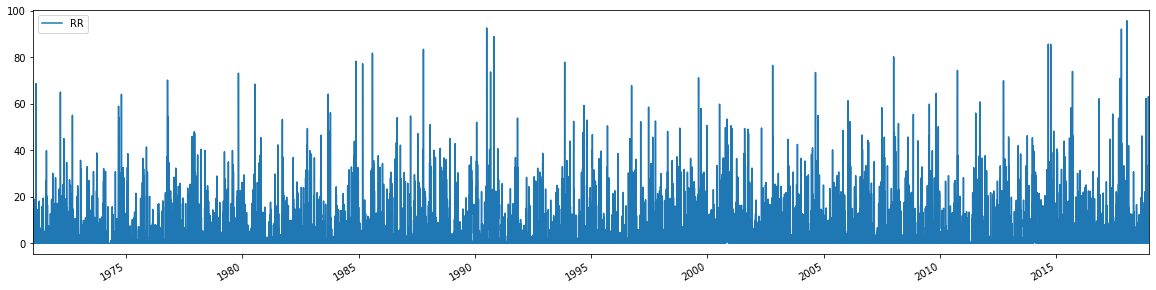

In [14]:
# Getting area-weighted data
def getWeightedData(filename,variable,save=True,isTemperature=False):
    nc_data = xr.open_dataset(filename,chunks={'time':1000})
    time = nc_data.time.values
    total_weight = sum(weight)
    data = np.sum(np.sum((nc_data.variables[variable] * weightArray)/total_weight,axis=1),axis=1)
    if isTemperature:
        data-=272.15
    nc_data.close()
    if save:
        data_df = pd.DataFrame({variable:data},index=time)
        data_df.to_pickle('./{}.pickle'.format(variable))
        data_df.to_csv('./{}.csv'.format(variable))
    return data_df

temperature_df = getWeightedData(os.path.abspath('./TG_Storelva.nc'),'TG',isTemperature=True)
temperature_df.plot(figsize=(20,5))

rain_df = getWeightedData(os.path.abspath('./RR_Storelva.nc'),'RR')
rain_df.plot(figsize=(20,5))


In [15]:
display(temperature_df)

,TG
1970-12-31 18:00:00,-7.868920
1971-01-02 18:00:00,-8.837877
1971-01-03 18:00:00,-2.234969
1971-01-04 18:00:00,1.551972
1971-01-05 18:00:00,-7.088735
1971-01-06 18:00:00,-7.671552
1971-01-07 18:00:00,2.405904
1971-01-08 18:00:00,6.412597
1971-01-09 18:00:00,6.399588
1971-01-10 18:00:00,6.671335


In [16]:
basinGenerator.kill()